# Evaluate Accuracy of the Oracle

We simulate the oracle based on the neutrality results of user studies in AAAI-14 paper. We know the percentages of neutral values per k-words documetns but not per snippet forms. 

Test: 
* Oracle accuracy
* Oracle neutrality

In [1]:
DATA = 'C:/Users/mramire8/Documents/Research/Oracle confidence and Interruption/dataset/aclImdb/raw-data'
import sys
import os
sys.path.append(os.path.abspath('C:/cygwin/home/mramire8/python_code/structured/'))
sys.path.append(os.path.abspath('/Users/maru/MyCode/structured/'))



In [2]:

import learner

from utilities.datautils import load_dataset
import utilities.experimentutils as exputil
import numpy as np
import experiment.base as exp
import nltk

# Read data (optionally from a pickled file if present)
import pickle


from time import time
import pickle


## Get the data ready
imdb_path = 'C:/Users/mramire8/Documents/Research/Oracle confidence and Interruption/dataset/aclImdb/raw-data'
imdb_path = '/Users/maru/MyCode/data/imdb'



In [3]:
vct = exputil.get_vectorizer({'vectorizer':'bow', 'limit':None, 'min_size':2})

imdb =  load_dataset("imdb",imdb_path, keep_subject=True)
# sraa = load_dataset("aviation", 100, categories[0], vct2, 100, raw=True,  percent=.5, keep_subject=True)

imdb.train.bow = vct.fit_transform(imdb.train.data)



In [9]:
oracle = exputil.get_classifier('lrl1', parameter=0.3)
oracle.fit(imdb.train.bow, imdb.train.target)
imdb.test.bow = vct.transform(imdb.test.data)


In [10]:
import nltk
sent_tk = nltk.data.load('tokenizers/punkt/english.pickle')

d_sent = sent_tk.tokenize_sents(imdb.test.data)

In [11]:
from sklearn import metrics
from collections import defaultdict
def test_oracle(ora_clf, doc_sents, doc_y, sizes, vct, threshold=None):
    
    results = defaultdict(lambda: [])
    
    for sents,y in zip(doc_sents, doc_y):
        if len(sents) > 0:
            bow = vct.transform(sents)
            probs = ora_clf.predict_proba(bow)
            unc = probs.min(axis=1)
            preds = ora_clf.predict(bow)
            nonneu = unc < threshold
            results['confidence'].extend(1-unc)
            acc = metrics.accuracy_score([y] *len(preds[nonneu]) ,preds[nonneu])
            if sum(nonneu)>0:
                results['accu'].append(acc)
                results['ce_noneutrals'].extend(unc[nonneu])
            results['noneutrals'].append(1. * sum(nonneu) / len(nonneu) )
            results['size'].extend([len(s.split()) for s in sents])
            results['preds'].extend(preds[nonneu])
            results['trues'].extend([y] *len(preds[nonneu]))
    return results


## CE without neutrals

In [12]:
res = test_oracle(oracle, d_sent, imdb.test.target, [1], vct,threshold=0.4)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/_methods.py:71: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [13]:
import numpy as np 
from scipy import stats

def describe(v):
    n, min_max, mean, var, skew, kurt = stats.describe(v)
    return  "N:{},\tmin:{:>7.3f},\tmax:{:>7.3f},\tmean:{:>7.3f},\tstd.:{:>7.3f}".format(n, min_max[0], min_max[1], mean, var)

def print_describe(res):
    for k,v in res.items():
        print  "{:<15} {}".format(k,describe(v))
        
print_describe(res)


confidence      N:304952,	min:  0.500,	max:  1.000,	mean:  0.646,	std.:  0.013
ce_noneutrals   N:172774,	min:  0.000,	max:  0.400,	mean:  0.279,	std.:  0.009
preds           N:172774,	min:  0.000,	max:  1.000,	mean:  0.625,	std.:  0.234
noneutrals      N:24989,	min:  0.000,	max:  1.000,	mean:  0.601,	std.:  0.036
accu            N:24904,	min:  0.000,	max:  1.000,	mean:  0.750,	std.:  0.062
trues           N:172774,	min:  0.000,	max:  1.000,	mean:  0.520,	std.:  0.250
size            N:304952,	min:  1.000,	max:472.000,	mean: 18.554,	std.:176.596


In [157]:
print "Accuracy:", metrics.accuracy_score(res['trues'], res['preds'])
ce = np.mean(1 - all_preds2.max(axis=1))
print "Avg. CE:", ce

for n in range(5,30,5):
    print "%s - scale= %.3f" % (n/100., (n/100.) / ce)

Accuracy: 0.736798176439


In [278]:
snip = exputil.get_tokenizer('snippet',snip_size=(2,2))
snip2=  snip.tokenize_sents(imdb.test.data)

In [279]:
res2 = test_oracle(oracle, snip2, imdb.test.target, [1], vct, threshold=0.3)
print_describe(res2)
print "Accuracy:", metrics.accuracy_score(res2['trues'], res2['preds'])

confidence      N:2176685,	min:  0.500,	max:  1.000,	mean:  0.696,	std.:  0.017
ce_noneutrals   N:1528189,	min:  0.000,	max:  0.400,	mean:  0.242,	std.:  0.011
preds           N:1528189,	min:  0.000,	max:  1.000,	mean:  0.544,	std.:  0.248
noneutrals      N:24989,	min:  0.000,	max:  1.000,	mean:  0.754,	std.:  0.024
accu            N:24931,	min:  0.000,	max:  1.000,	mean:  0.794,	std.:  0.052
trues           N:1528189,	min:  0.000,	max:  1.000,	mean:  0.491,	std.:  0.250
size            N:2176685,	min:  2.000,	max:723.000,	mean: 36.680,	std.:358.692
Accuracy: 0.763455959963


In [137]:
print metrics.accuracy_score(imdb.test.target, oracle.predict(imdb.test.bow))


0.89519388531


In [139]:
print "Avg. s=1:", np.mean([len(ss) for s in d_sent])
print "Avg. s=2:", np.mean([len(s) for s in snip2])



Avg. s=1: 12.2034495178
Avg. s=2: 87.0972828044


In [146]:
s1= np.array([[len(c.split()) for c in r] for r in d_sent])

24989


## Statistics of Snippet sizes - IMDB

Compute neutrality, accuracy of the oracle on first-1, 2, and 3 snippets. 

In [15]:
snipk = {}
for s in range(1,6):
    tk = exputil.get_tokenizer('first1snippet',snip_size=(s,s))
    data = tk.tokenize_sents(imdb.test.data)
    snipk[s] = test_oracle(oracle, data, imdb.test.target, [1], vct,threshold=0.4)
    print "== K = %s ===" % s
    print_describe(snipk[s])
    print "Accuracy: %.3f" % metrics.accuracy_score(snipk[s]['trues'], snipk[s]['preds'])
    print "Neutrality: %.3f" % (1- 1.* len(snipk[s]['trues'])/len(snipk[s]['confidence']))
    print "CE: %.3f" % (1. - np.mean(snipk[s]['confidence']))
    

== K = 1 ===
confidence      N:24989,	min:  0.500,	max:  1.000,	mean:  0.667,	std.:  0.015
ce_noneutrals   N:15679,	min:  0.000,	max:  0.400,	mean:  0.263,	std.:  0.010
preds           N:15679,	min:  0.000,	max:  1.000,	mean:  0.650,	std.:  0.227
noneutrals      N:24989,	min:  0.000,	max:  1.000,	mean:  0.627,	std.:  0.234
accu            N:15679,	min:  0.000,	max:  1.000,	mean:  0.759,	std.:  0.183
trues           N:15679,	min:  0.000,	max:  1.000,	mean:  0.533,	std.:  0.249
size            N:24989,	min:  1.000,	max:472.000,	mean: 20.515,	std.:355.384
Accuracy: 0.759
Neutrality: 0.373
CE: 0.333
== K = 2 ===
confidence      N:24989,	min:  0.500,	max:  1.000,	mean:  0.728,	std.:  0.020
ce_noneutrals   N:19151,	min:  0.000,	max:  0.400,	mean:  0.217,	std.:  0.013
preds           N:19151,	min:  0.000,	max:  1.000,	mean:  0.578,	std.:  0.244
noneutrals      N:24989,	min:  0.000,	max:  1.000,	mean:  0.766,	std.:  0.179
accu            N:19151,	min:  0.000,	max:  1.000,	mean:  0.791,	std.:  

In [223]:
snipk2 = {}
for s in range(6,8):
    tk = exputil.get_tokenizer('first1snippet',snip_size=(s,s))
    data = tk.tokenize_sents(imdb.test.data)
    snipk2[s] = test_oracle(oracle, data, imdb.test.target, [1], vct)
    print "== K = %s ===" % s
    print_describe(snipk2[s])
    print "Accuracy: %.3f" % metrics.accuracy_score(snipk2[s]['trues'], snipk2[s]['preds'])
    print "Neutrality: %.3f" % (1- 1.* len(snipk2[s]['trues'])/len(snipk2[s]['confidence']))
    print "CE: %.3f" % (1. - np.mean(snipk2[s]['confidence']))
 

== K = 6 ===
confidence      N:24989,	min:  0.500,	max:  1.000,	mean:  0.838,	std.:  0.022
preds           N:22381,	min:  0.000,	max:  1.000,	mean:  0.514,	std.:  0.250
noneutrals      N:24989,	min:  0.000,	max:  1.000,	mean:  0.896,	std.:  0.093
accu            N:22381,	min:  0.000,	max:  1.000,	mean:  0.868,	std.:  0.115
trues           N:22381,	min:  0.000,	max:  1.000,	mean:  0.499,	std.:  0.250
size            N:24989,	min:  7.000,	max:941.000,	mean:112.496,	std.:2019.977
Accuracy: 0.868
Neutrality: 0.104
CE: 0.162
== K = 7 ===
confidence      N:24989,	min:  0.500,	max:  1.000,	mean:  0.849,	std.:  0.022
preds           N:22607,	min:  0.000,	max:  1.000,	mean:  0.509,	std.:  0.250
noneutrals      N:24989,	min:  0.000,	max:  1.000,	mean:  0.905,	std.:  0.086
accu            N:22607,	min:  0.000,	max:  1.000,	mean:  0.875,	std.:  0.109
trues           N:22607,	min:  0.000,	max:  1.000,	mean:  0.499,	std.:  0.250
size            N:24989,	min: 11.000,	max:941.000,	mean:126.695,	std.:2

In [227]:
all_sizes = [len(s) for s in d_sent]
print np.mean(all_sizes)
print np.sum(all_sizes)

12.2034495178
304952


In [228]:
all_sents = []
targets = []
for s, y in zip(d_sent, imdb.test.target):
    for ss in s:
        all_sents.append(ss)
        targets.append(y)

all_bow = vct.transform(all_sents)
all_preds = oracle.predict_proba(all_bow)


In [232]:
print all_preds.shape
ce = np.mean(1 - all_preds.max(axis=1))
print "Avg. CE:", ce

(304952L, 2L)
Avg. CE: 0.352715583331


In [238]:
for n in range(5,30,5):
    print "%s - scale= %.3f" % (n/100., (n/100.) / ce)

0.05 - scale= 0.142
0.1 - scale= 0.284
0.15 - scale= 0.425
0.2 - scale= 0.567
0.25 - scale= 0.709


In [237]:
0.353*0.284

0.10025199999999998

## Statistics of Snippet Sizes - SRAA



In [26]:
sraa_path ='C:/Users/mramire8/Documents/Research/Oracle confidence and Interruption/dataset/sraa/sraa/sraa/partition1/data'
sraa_path = '/Users/maru/MyCode/data/sraa'
sraa =  load_dataset("sraa",sraa_path, keep_subject=True)
vct2 = exputil.get_vectorizer({'vectorizer':'bow', 'limit':None, 'min_size':2})
sraa.train.bow = vct2.fit_transform(sraa.train.data)

sraa_sent = sent_tk.tokenize_sents(sraa.test.data)

In [27]:
oracle2 = exputil.get_classifier('lrl1', parameter=0.01)
oracle2.fit(sraa.train.bow, sraa.train.target)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [28]:
snipk2 = {}
for s in range(1,6):
    tk = exputil.get_tokenizer('first1snippet',snip_size=(s,s))
    data = tk.tokenize_sents(sraa.test.data)
    snipk2[s] = test_oracle(oracle2, data, sraa.test.target, [1], vct2,threshold=0.3)
    print "== K = %s ===" % s
    print_describe(snipk2[s])
    print "Accuracy: %.3f" % metrics.accuracy_score(snipk2[s]['trues'], snipk2[s]['preds'])
    print "Neutrality: %.3f" % (1- 1.* len(snipk2[s]['trues'])/len(snipk2[s]['confidence']))
    print "CE: %.3f" % (1. - np.mean(snipk2[s]['confidence']))
  

== K = 1 ===
confidence      N:36603,	min:  0.500,	max:  1.000,	mean:  0.745,	std.:  0.032
ce_noneutrals   N:17863,	min:  0.000,	max:  0.299,	mean:  0.083,	std.:  0.006
preds           N:17863,	min:  0.000,	max:  1.000,	mean:  0.271,	std.:  0.198
noneutrals      N:36603,	min:  0.000,	max:  1.000,	mean:  0.488,	std.:  0.250
accu            N:17863,	min:  0.000,	max:  1.000,	mean:  0.994,	std.:  0.006
trues           N:17863,	min:  0.000,	max:  1.000,	mean:  0.273,	std.:  0.198
size            N:36603,	min:  1.000,	max:739.000,	mean: 19.241,	std.:304.390
Accuracy: 0.994
Neutrality: 0.512
CE: 0.255
== K = 2 ===
confidence      N:36603,	min:  0.500,	max:  1.000,	mean:  0.784,	std.:  0.032
ce_noneutrals   N:21848,	min:  0.000,	max:  0.299,	mean:  0.078,	std.:  0.006
preds           N:21848,	min:  0.000,	max:  1.000,	mean:  0.302,	std.:  0.211
noneutrals      N:36603,	min:  0.000,	max:  1.000,	mean:  0.597,	std.:  0.241
accu            N:21848,	min:  0.000,	max:  1.000,	mean:  0.992,	std.:  

In [ ]:
# sraa.test.bow = vct2.transform(sraa.test.data)
all_sents = []
targets = []
for s, y in zip(sraa_sent, sraa.test.target):
    for ss in s:
        all_sents.append(ss)
        targets.append(y)

all_bow2 = vct2.transform(all_sents)
all_preds2 = oracle.predict_proba(all_bow2)

all_sizes2 = [len(s) for s in sraa_sent]


In [243]:

print "Avg. size:", np.mean(all_sizes2)
print "N:", np.sum(all_sizes2)

print all_preds2.shape
ce = np.mean(1 - all_preds2.max(axis=1))
print "Avg. CE:", ce

for n in range(5,30,5):
    print "%s - scale= %.3f" % (n/100., (n/100.) / ce)

Avg. size: 10.4467120181
N: 382381
(382381L, 2L)
Avg. CE: 0.362268882632
0.05 - scale= 0.138
0.1 - scale= 0.276
0.15 - scale= 0.414
0.2 - scale= 0.552
0.25 - scale= 0.690


In [379]:
tmp = all_preds2[all_preds2.min(axis=1) < 0.3]
non_ce = np.mean(1 - tmp.max(axis=1))
print "Non-neutral CE SRAA", non_ce

for n in range(5,30,5):
    print "%s - scale= %.3f" % (n/100., (n/100.) / non_ce)

Non-neutral CE SRAA 0.106329111295
0.05 - scale= 0.470
0.1 - scale= 0.940
0.15 - scale= 1.411
0.2 - scale= 1.881
0.25 - scale= 2.351


In [376]:
res22 = test_oracle(oracle2, sraa_sent, sraa.test.target, [1], vct2)
print_describe(res22)


confidence      N:382381,	min:  0.500,	max:  1.000,	mean:  0.645,	std.:  0.024
ce_noneutrals   N:113914,	min:  0.000,	max:  0.400,	mean:  0.138,	std.:  0.012
preds           N:113914,	min:  0.000,	max:  1.000,	mean:  0.334,	std.:  0.222
noneutrals      N:36603,	min:  0.000,	max:  1.000,	mean:  0.322,	std.:  0.055
accu            N:31241,	min:  0.000,	max:  1.000,	mean:  0.967,	std.:  0.020
trues           N:113914,	min:  0.000,	max:  1.000,	mean:  0.349,	std.:  0.227
size            N:382381,	min:  1.000,	max:4185.000,	mean: 16.542,	std.:273.679


## Converting Snippets into Big Snippets

Get snippets of size one, and convert into other sizes by adding the vectors 

Steps: 
1. Convert to sentences
1. Convert all sentences to a sparse matrix
1. Save data in...file
1. Create method to create snippets 

In [300]:
from sklearn.preprocessing import binarize
import itertools
pairs = itertools.combinations(range(5),3)
print all_bow.shape
for pair in pairs: 
    bin_bow = binarize(all_bow[list(pair)].sum(axis=0))
    print bin_bow.shape
    # stack the vector in a matrix
    # return one matrix per document
    break

(304952, 267154)
(1L, 267154L)


In [297]:
mat = np.random.randint(0, high=2,size=(5,3))
print mat
from scipy.sparse import *
sp_mat = csr_matrix(mat)


[[1 0 1]
 [1 0 1]
 [1 1 0]
 [0 1 1]
 [1 0 0]]


In [298]:
pairs = itertools.combinations(range(5),3)
print mat
for pair in pairs: 
    bin_bow = binarize(sp_mat[list(pair)].sum(axis=0))
    temp = csr_matrix(bin_bow.todense())
    print temp.indices
    print temp.data
    print temp.indptr

AttributeError: 'numpy.ndarray' object has no attribute 'todense'

In [342]:
## Perform an OR between two rows of a sparse matrix
ai = sp_mat[2].indices
bi = sp_mat[1].indices
oi = np.array(list(set(ai) | set(bi)))
output = csr_matrix(([1]*len(oi), oi, [0, len(oi)]), shape=(1, sp_mat.shape[1]), dtype=int)
print output.toarray()
                    

[[1 1 1]]


In [341]:
print sp_mat[0].toarray()

[[1 0 1]]


In [331]:
print voc

{'dos': 0, 'tres': 2, 'uno': 1}


In [372]:
## Creating a sliding window
# This creates the indices 
ch = range(6)
ws = min(len(ch), 2)
for c in range(len(ch)-ws+1):
    print ch[c:c+ws]

[0, 1]
[1, 2]
[2, 3]
[3, 4]
[4, 5]


# Snippet Average Annotation Cost

We test all snippets for the real annotation cost according to the function of interporlation

Test for every snippet size, the average annotation cost. 

In [8]:
# Annotation cost function
def fn_int(x, cost, kvalues):
    
    binx = min(np.digitize([x], kvalues)[0], len(cost)-1)
    lbbinx = max(binx-1, 0) 
#     print binx, lbbinx
    y1 = cost[lbbinx] if lbbinx>=0  else 0
    y2 = cost[binx]
    x1 = kvalues[lbbinx] if lbbinx >=0 else 0
    x2 = kvalues[binx]
#     print x1,x2,y1,y2
    
    m = (y2-y1) / (x2-x1)
    b = y2 - m * x2
    
    if x < kvalues[0]:
        y = cost[0]
    elif x > kvalues[-1] :
        y = cost[-1]
    else:
        y = (m * x) + b
    return y
kvalues = [10, 25, 50, 75, 100]
cost = np.array([5.7, 8.2, 10.9, 15.9, 16.7])
cost2=np.array([5.2, 6.5, 7.6,9.1,10.3])
print fn_int(98, cost, kvalues)

16.636


In [14]:
# Cost of the average size snippet for 1 entences in IMDB
print fn_int(18.554, cost, kvalues)

7.12566666667


In [21]:
type(snipk[1]['size'][0])

int

In [45]:
def average_cost(stats, cost, kvalues):
    res = {}
    for k,v in stats.items():
        print "K=%s" %k
        sizes = np.array([fn_int(s, cost, kvalues) for s in v['size']])
        print "Average cost: %s +/- %s (n=%s)" % (np.mean(sizes),np.std(sizes), sizes.shape[0])
        res[k]=sizes
    return res
print "==IMDB== "
s_imdb = average_cost(snipk, cost, kvalues)

==IMDB== 
K=1
Average cost: 7.33307268531 +/- 1.93856371729 (n=24989)
K=2
Average cost: 9.90620006136 +/- 2.65427916985 (n=24989)
K=3
Average cost: 12.3249025304 +/- 2.95010631015 (n=24989)
K=4
Average cost: 14.1969419078 +/- 2.65721835861 (n=24989)
K=5
Average cost: 15.318015927 +/- 2.13776465034 (n=24989)


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: RuntimeWarning: invalid value encountered in double_scalars


In [102]:
print "\n".join(["{}\t{}".format(s[0],fn_int(s[1], cost, kvalues)) for s in [(k, np.mean(snipk[k]['size'])) for k in snipk.keys()]])

1	7.45242440007
2	9.88378262435
3	12.9389851535
4	16.0264479571
5	16.5875050622


In [46]:
print "==SRAA== "
s_sraa = average_cost(snipk2, cost2, kvalues)

==SRAA== 
K=1
Average cost: 5.94106497646 +/- 0.897758420076 (n=36603)
K=2
Average cost: 6.92652722454 +/- 1.06643355765 (n=36603)
K=3
Average cost: 7.71319043066 +/- 1.18013475256 (n=36603)
K=4
Average cost: 8.34897922757 +/- 1.26881099588 (n=36603)
K=5
Average cost: 8.82394514111 +/- 1.31304034134 (n=36603)


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: RuntimeWarning: invalid value encountered in double_scalars


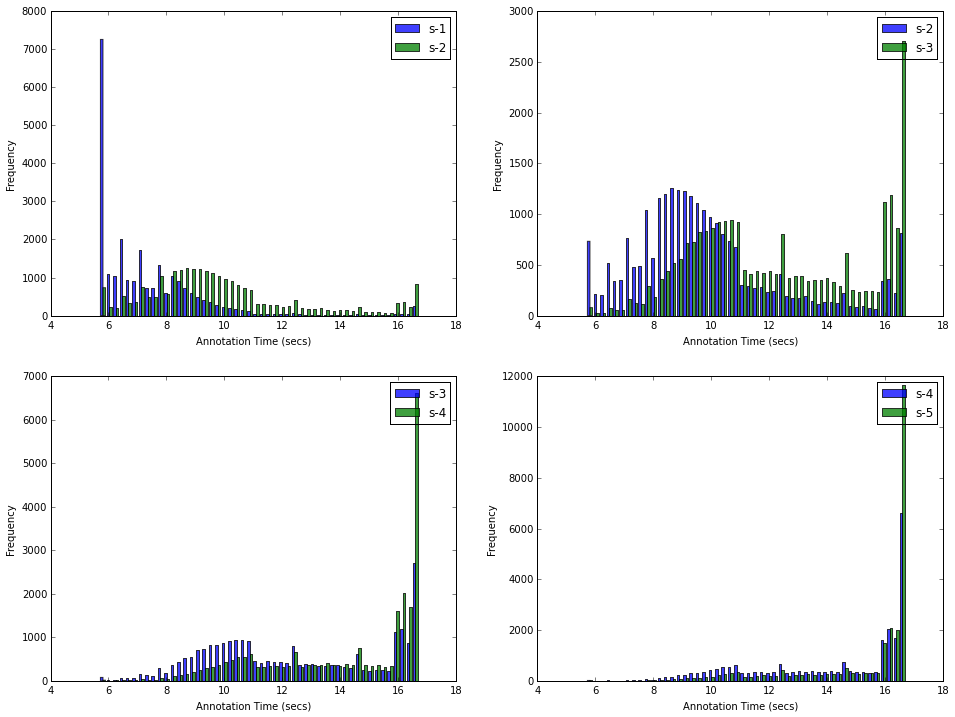

In [73]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
import pylab

pylab.rcParams['figure.figsize'] = (16, 12)

def plot_hist_cost(sk):

    for k in sk.keys()[:-1]:
        plt.subplot(2,2,k)
        plt.hist([sk[k], sk[k+1]],bins=50, label=['s-{}'.format(l) for l in [k, k+1]], alpha=.75)
        plt.legend()
        plt.xlabel('Annotation Time (secs)')
        plt.ylabel('Frequency')

plot_hist_cost(s_imdb)
    

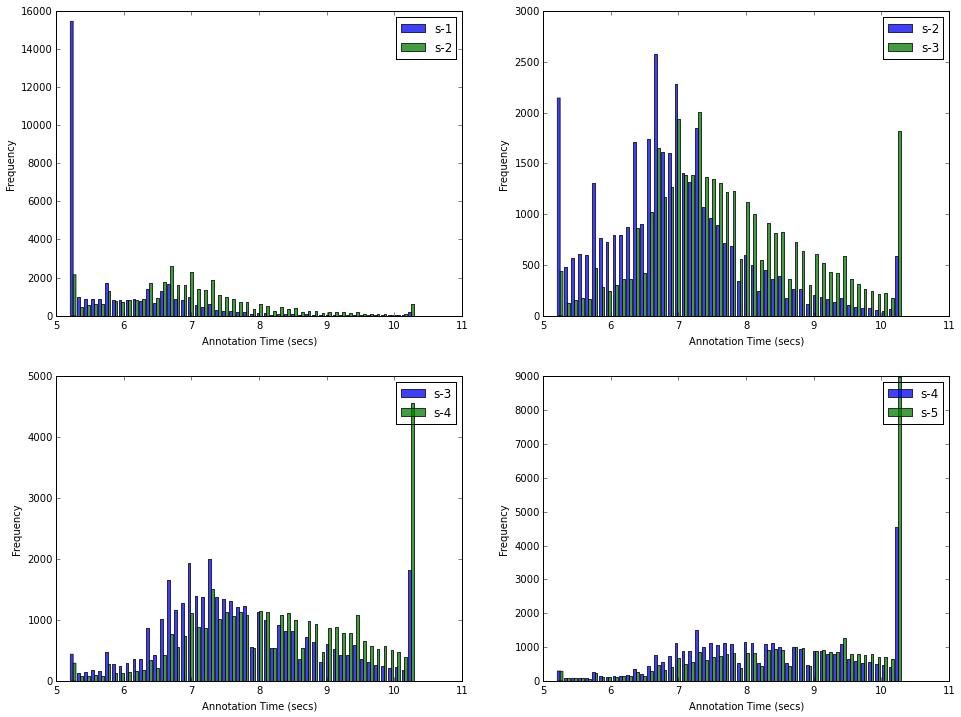

In [74]:
plot_hist_cost(s_sraa)

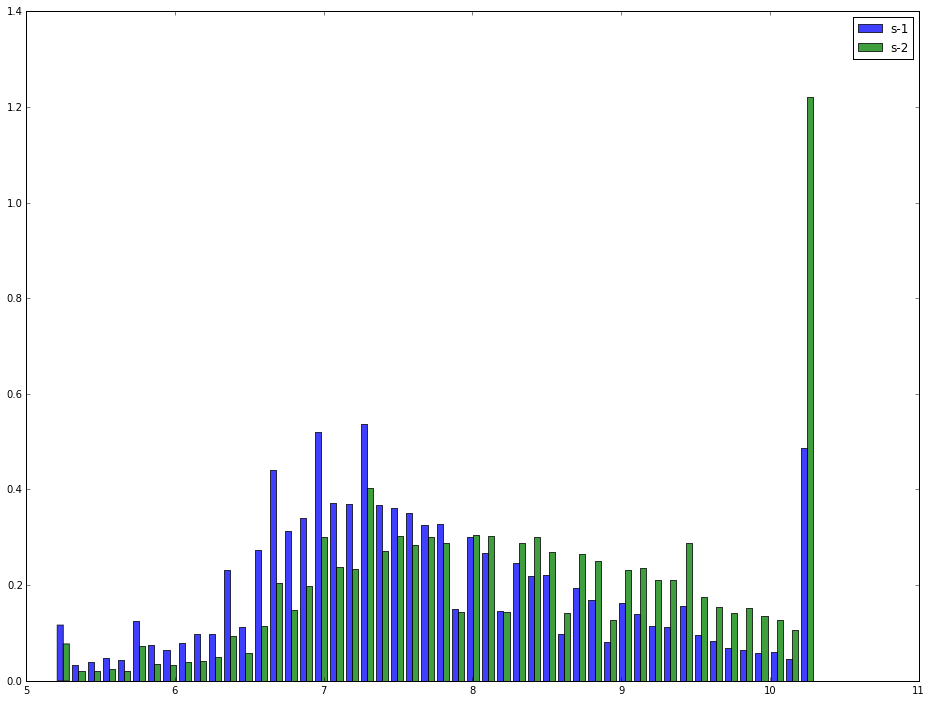

In [93]:
plt.hist([s_sraa[3], s_sraa[4]],bins=50, label=['s-1','s-2'], alpha=.75, normed=True)
plt.legend()


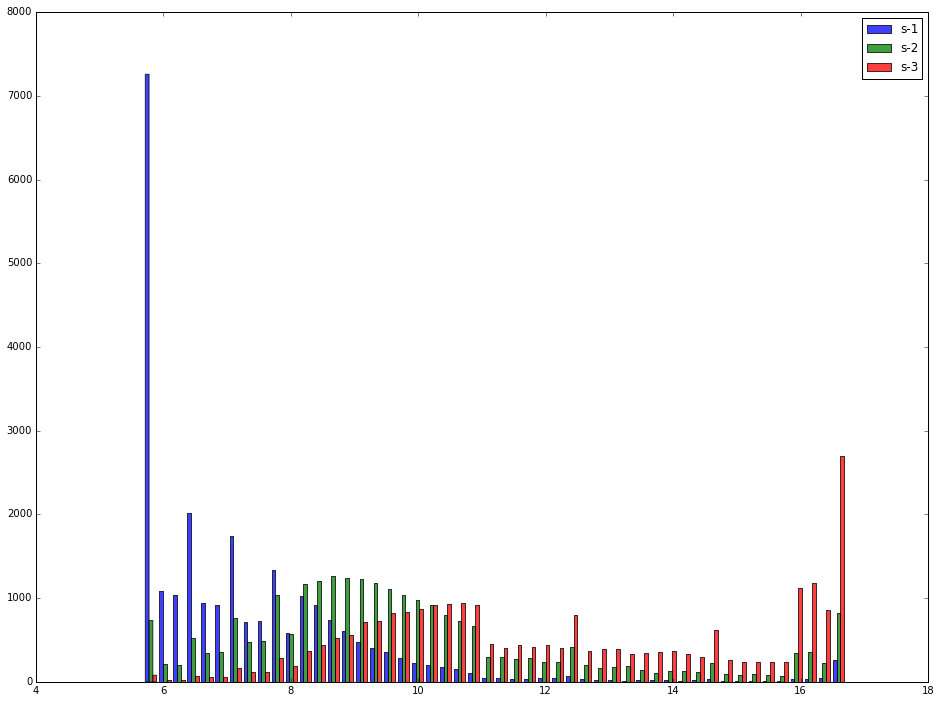

In [96]:
plt.hist(s_imdb.values()[:-2],bins=50, label=['s-{}'.format(k) for k in s_imdb.keys()[:-2]], alpha=.75, )
plt.legend()